In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [93]:
df = pd.read_csv('Stocks\GOOG.csv')

## Quick look at data

In [94]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-04-22,61.799500,62.454498,61.415501,62.442001,62.442001,16146000
1,2019-04-23,62.534500,63.450001,62.319000,63.227501,63.227501,26398000
2,2019-04-24,63.206001,63.400501,62.750000,62.799999,62.799999,20376000
3,2019-04-25,63.238499,63.370399,62.601501,63.172501,63.172501,22146000
4,2019-04-26,63.450001,63.653500,63.015999,63.609001,63.609001,24828000


**We will deal with the closing price for each day.**

In [95]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close']]

In [96]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Close   1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


**Data Time Period**

In [97]:
df['Date'].min(), df['Date'].max()

('2019-04-22', '2024-04-19')

## Visualize the data

In [98]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

## Data Preprocessing

#### 1. Train - test split

In [99]:
train = df.loc[df['Date'] <= '2023-12-24']
test = df.loc[df['Date'] > '2023-12-24']
train.shape, test.shape

((1179, 2), (80, 2))

#### 2. Data Scaling

In [100]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

C:\Users\ragam\AppData\Local\Temp\ipykernel_24012\3901342107.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ragam\AppData\Local\Temp\ipykernel_24012\3901342107.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
train.head()

,Date,Close
0,2019-04-22,-1.334878
1,2019-04-23,-1.307831
2,2019-04-24,-1.322551
3,2019-04-25,-1.309725
4,2019-04-26,-1.294695


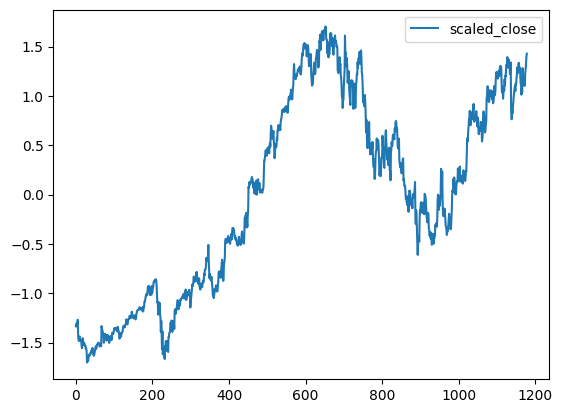

In [102]:
# Visualize scaled data
plt.plot(train['Close'], label = 'scaled_close')
plt.legend()
plt.show()

#### 3. Create sequences
- Create sequences combining `TIME_STEPS` contiguous data values from the training data.
- `TIME_STEP` is set 30 as we want our network to have memory of 30 days.

In [103]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (1149, 30, 1)
Testing input shape:  (50, 30, 1)


In [120]:
print(X_train.shape)
print(y_train.shape)

(1149, 30, 1)
(1149,)


In [121]:
y_train[0]

-1.6719564586786948

In [119]:
print(len(train))
print(len(test))

1179
80


In [105]:
X_train[1100].shape

(30, 1)

In [106]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)

## Build a model

We are building LSTM Autoencoder model. The model will take input of shape `(batch_size, sequence_length, num_features)` and return output of the same shape. In this case, `sequence_length is 30` and `num_features is 1`.

In [107]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

e:\AIO\AnamolyDetection_NLP_Time_Series\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [108]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.6872 - val_loss: 0.2915
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1082 - val_loss: 0.0660
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0634 - val_loss: 0.0745
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0740 - val_loss: 0.0623
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0922 - val_loss: 0.0547
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1068 - val_loss: 0.0675
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1187 - val_loss: 0.0654
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1242 - val_loss: 0.0543
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.1054 - val_loss: 0.0577
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0968 - val_loss: 0.0660
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0840 - val_loss: 0.0733
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

#### Plot Training - Validation loss

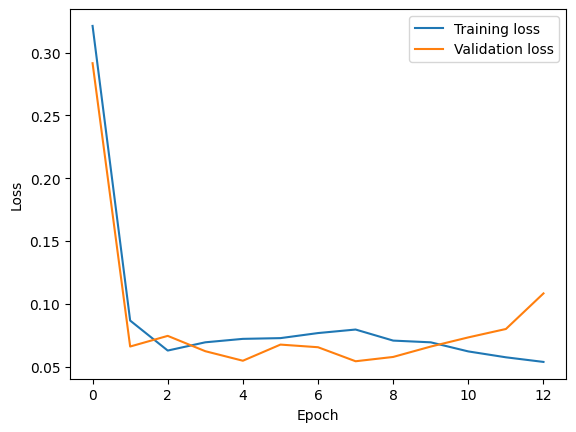

In [109]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Reconstruction error threshold: 0.5567852176636374


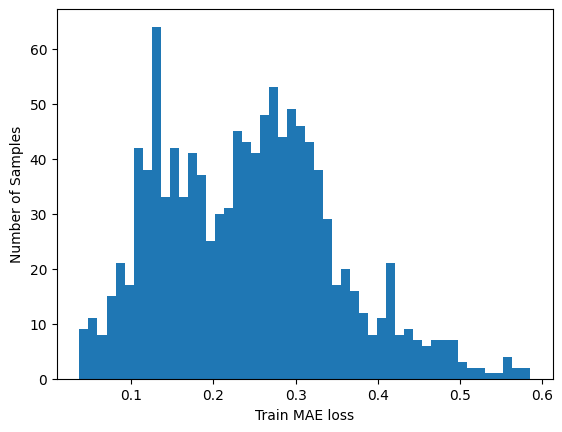

In [110]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)
threshold = threshold - 0.05*threshold

print('Reconstruction error threshold:',threshold)

### Reconstruction error threshold: 0.48992275269204094

## Predict Anomalies on test data using threshold

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Text(0, 0.5, 'Number of samples')

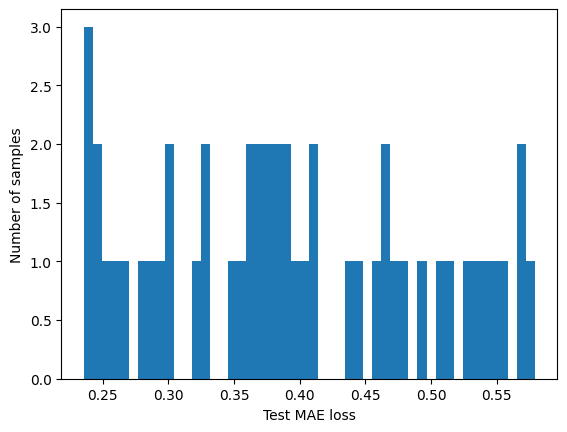

In [111]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [112]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [113]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
1209,2024-02-08,1.584255,0.375838,0.556785,False
1210,2024-02-09,1.687553,0.375250,0.556785,False
1211,2024-02-12,1.636249,0.365375,0.556785,False
1212,2024-02-13,1.554987,0.366432,0.556785,False
1213,2024-02-14,1.581501,0.380303,0.556785,False


In [114]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [115]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
1227,2024-03-06,1.079472,0.568738,0.556785,True
1228,2024-03-07,1.171752,0.578943,0.556785,True
1229,2024-03-08,1.207906,0.568305,0.556785,True


In [116]:
anomalies.shape

(3, 5)

In [117]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.